In [1]:
%matplotlib notebook
%matplotlib inline

import os
from packaging import version
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb

plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Helvetica"
# })
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# experiment_id, experiment_name = "6yl48QRjSySDUpTg8TpeRw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_29d20f8"
# experiment_id, experiment_name = "zNo4qyA5RBybC9m0sPRiZw", "st_uc-bg_bigBugfixMetric_bs4_split_1_1_trial1_b4f39ae"
# experiment_id, experiment_name = "7M4Qi6dmQteoRpuOibFbWQ", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"

# experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
# df = experiment.get_scalars()
# df.to_csv(f"metrics_{experiment_name}.csv", index=False)

# df = pd.read_csv(f"metrics_{experiment_name}.csv")

In [ ]:
# def draw_metrics(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors=None):
#     f, axes = plt.subplots(1, 2, sharey=True, figsize=(10,4))
#     base_run = "tensorboard"
#     if y_label is None:
#         y_label = "ROI IoU wrt. pseudo-labels"
#     # classes = ["Car", "Pedestrian", "Cyclist"]
#     classes = ["Car", "Pedestrian"]
#     if tags is None:
#         tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
#     if tag_names is None:
#         tag_names = ["True Positive ROIs", "False Positive ROIs", "False Negative ROIs"]
#     if colors is None : 
#         colors = ['green', 'blue', 'red']
#     for j, cls in enumerate(classes):
#         for exp in range(2):
#             df = dfs[exp]
#             for k, (tag, tname, color) in enumerate(zip(tags, tag_names, colors)):
#                 tname += '/after' if exp == 1 else '/before'
#                 linestyle = 'solid' if exp == 1 else 'dashed'
#                 run = base_run + "/" + tag + "/" + cls
#                 steps = df[df.run == run].step
#                 values = df[df.run == run].value
#                 smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
#                 if j == 0:
#                     lines = axes[j].plot(steps, values, alpha=0.1, color=color)
#                     axes[j].plot(steps, smooth_values, label=tname, color=color, linestyle=linestyle)
#                     axes[j].set_ylabel(y_label)
#                 else:
#                     lines = axes[j].plot(steps, values, alpha=0.1, color=color)
#                     axes[j].plot(steps, smooth_values, color=color, linestyle=linestyle)

#             axes[j].yaxis.set_tick_params(labelleft=True)

#             if j == 0:
#                 if threshs is not None:
#                     axes[j].axhline(y=threshs[j], linestyle="dashed", label="$\\tau$")
#             if j == 1 or j == 2:
#                 if threshs is not None:
#                     axes[j].axhline(y=threshs[j], linestyle="dashed")
#                 axes[j].yaxis.set_tick_params(labelleft=False)

#             axes[j].set_title(cls)
#             axes[j].xaxis.set_tick_params(labelbottom=False)
#             axes[j].set_xlabel("Training iterations")

#     axes[0].legend()
#     f.tight_layout()
#     f.subplots_adjust(wspace=0.02, hspace=0.02)
#     f.savefig(fname=fname, transparent=False, bbox_inches='tight')

In [ ]:
# def draw_metrics_iou(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors = None):
#     # f, axes = plt.subplots(1, 3, sharey=True, figsize=(13,4))
#     f, axes = plt.subplots(2, 3, sharey=True, figsize=(10,5))
#     base_run = "tensorboard"
#     if y_label is None:
#         y_label = "ROI IoU wrt. pseudo-labels"
#     # classes = ["Car", "Pedestrian", "Cyclist"]
#     classes = ["Car", "Pedestrian"]
#     if tags is None:
#         tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
#     if tag_names is None:
#         tag_names = ["True Positive ROIs", "False Positive ROIs", "False Negative ROIs"]
#     if colors is None : 
#         colors = ['green', 'blue', 'red']
#     for i in range(2):
#         df = dfs[i]
#         for j, cls in enumerate(classes):
#             for k, (tag, tname, color) in enumerate(zip(tags, tag_names, colors)):
#                 run = base_run + "/" + tag + "/" + cls
#                 steps = df[df.run == run].step
#                 values = df[df.run == run].value
#                 smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
#                 if j == 0:
#                     lines = axes[i, j].plot(steps, values, alpha=0.2, color=color)
#                     axes[i, j].plot(steps, smooth_values, label=tname, color=color)
#                     axes[i, j].set_ylabel(y_label)
#                 else:
#                     lines = axes[i, j].plot(steps, values, alpha=0.2, color=color)
#                     axes[i, j].plot(steps, smooth_values, color=color)

#             axes[i, j].yaxis.set_tick_params(labelleft=True)

#             if j == 0:
#                 if threshs is not None:
#                     axes[i, j].axhline(y=threshs[i, j], linestyle="dashed", label="$\\tau$")
#             if j == 1 or j == 2:
#                 if threshs is not None:
#                     axes[i, j].axhline(y=threshs[i, j], linestyle="dashed")
#                 axes[i, j].yaxis.set_tick_params(labelleft=False)
#             if i == 0:
#                 axes[i, j].set_title(cls)
#                 axes[i, j].xaxis.set_tick_params(labelbottom=False)
#             if i == 1:
#                 axes[i, j].set_xlabel("Training iterations")

#     axes[0, 0].legend()
#     f.tight_layout()
#     f.subplots_adjust(wspace=0.02, hspace=0.02)
#     f.savefig(fname=fname, transparent=False, bbox_inches='tight')

In [ ]:
# def draw_metrics_correlation(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors=None):
#     f, axes = plt.subplots(2, 1, sharey=True, figsize=(5,5))
#     base_run = "tensorboard"
#     # classes = ["Car", "Pedestrian", "Cyclist"]
#     classes = ["Car", "Pedestrian"]
#     x_y_values = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl", "rcnn_roi_pl_gt_metrics_cls/pred_weight"]
#     tags = ["tp", "fp", "fn"]
#     if colors is None : 
#         colors = ['green', 'blue', 'red']
#     subplot_titles = ['Before', 'After']
#     df = dfs[1]
#     for cls_idx, cls in enumerate(classes):
#         for tag_idx, (tag, color) in enumerate(zip(tags, colors)):
#             iou_tag = base_run + "/" + x_y_values[0] + "_" + tag + "/" + cls
#             weight_tag = base_run + "/" + x_y_values[1] + "_" + tag + "/" + cls
#             weight = df[df.run == weight_tag].value
#             iou = df[df.run == iou_tag].value
#             if cls_idx == 0:
#                 axes[cls_idx].scatter(iou, weight, label=tag, color=color, alpha = 0.5)
#             else:
#                 axes[cls_idx].scatter(iou, weight, color=color, alpha = 0.5)
#             axes[cls_idx].yaxis.set_tick_params(labelleft=True)
        
#         axes[cls_idx].set_title(cls)
#         axes[cls_idx].xaxis.set_tick_params(labelbottom=False)
#         axes[cls_idx].set_xlabel("IoUs")
#         axes[cls_idx].set_ylabel(y_label)
#         axes[cls_idx].legend()

#     f.tight_layout()
#     f.subplots_adjust(wspace=0.02, hspace=0.2)
#     f.savefig(fname=fname, transparent=False, bbox_inches='tight')

In [ ]:
# def draw_metrics_fg_ious_old(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors=None):
#     f, axes = plt.subplots(2, 1, sharey=True, figsize=(6,6))
#     base_run = "tensorboard"
#     if y_label is None:
#         y_label = "ROI IoU wrt. pseudo-labels"
#     classes = ["Car", "Pedestrian", "Cyclist"]
#     # classes = ["Car", "Pedestrian"]
#     if tags is None:
#         tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
#     if tag_names is None:
#         tag_names = ["True Positive ROIs", "False Positive ROIs", "False Negative ROIs"]
#     if colors is None : 
#         colors = ['green', 'blue', 'red']
#     subplot_titles = ['Before', 'After']
#     for j in range(len(subplot_titles)):
#         df = dfs[j]
#         for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
#             for k, (tag, tname) in enumerate(zip(tags, tag_names)):
#                 run = base_run + "/" + tag + "/" + cls
#                 steps = df[df.run == run].step
#                 values = df[df.run == run].value
#                 smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
#                 if j == 0:
#                     # lines = axes[j].plot(steps, values, alpha=0.1, color=color)
#                     axes[j].plot(steps, smooth_values, label=cls, color=color)
#                     sns.lineplot(ax=axes[j], data=smooth_values, x=steps, linewidth=2.5)
#                 else:
#                     # lines = axes[j].plot(steps, values, alpha=0.1, color=color)
#                     # axes[j].plot(steps, smooth_values, color=color)
#                     sns.lineplot(ax=axes[j], data=smooth_values, x=steps, linewidth=2.5)
#                 axes[j].yaxis.set_tick_params(labelleft=True)

#             if j == 0 and cls_idx == 0:
#                 if threshs is not None:
#                     axes[j].axhline(y=threshs[j][cls_idx], linestyle="dashed", label="$\\tau$", color='black')
#             if j == 1:
#                 if threshs is not None:
#                     axes[j].axhline(y=threshs[j][cls_idx], linestyle="dashed", label=("$\\tau_{cls}}$".replace('cls', cls)), color=color)
#                 axes[j].yaxis.set_tick_params(labelleft=True)

#         # axes[j].set_title(subplot_titles[j])
#         axes[j].xaxis.set_tick_params(labelbottom=False)
#         axes[j].set_xlabel("Training iterations")
#         axes[j].set_ylabel(y_label)
#         axes[j].legend()

#     f.tight_layout()
#     f.subplots_adjust(wspace=0.02, hspace=0.02)
#     f.savefig(fname=fname, transparent=False, bbox_inches='tight')

Draw metrics for FG IoUs between ROIs and PLs

In [ ]:
# def draw_metrics_fg_ious(dfs, fname, tags=None, tag_names=None, threshs=None, y_label=None, colors=None):
#     f, axes = plt.subplots(2, 1, sharey=True, figsize=(6,4))
#     base_run = "tensorboard"
#     if y_label is None:
#         y_label = "ROI IoU wrt. pseudo-labels"
#     classes = ["Car", "Pedestrian", "Cyclist"]
#     if tags is None:
#         tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
#     if tag_names is None:
#         tag_names = ["True Positive ROIs", "False Positive ROIs", "False Negative ROIs"]
#     if colors is None : 
#         colors = sns.color_palette('tab10', len(classes))
#         palette = {mode: color for mode, color in zip(classes, colors)}
#     subplot_titles = ['Before', 'After']
    
#     for j in range(len(subplot_titles)):
#         df = dfs[j]
#         classwise_df=pd.DataFrame()
#         for cls_idx, (cls, color) in enumerate(zip(classes, colors)):
#             for k, (tag, tname) in enumerate(zip(tags, tag_names)):
#                 run = base_run + "/" + tag + "/" + cls
#                 steps = df[df.run == run].step
#                 values = df[df.run == run].value
#                 smooth_values = df[df.run == run].ewm(alpha=0.2).mean().value
#                 # store all classwise IoUs in a single dataframe and plot all at once
#                 classwise_df[cls] = smooth_values.reset_index(drop=True)
            
#             # plot threshold lines 
#             if j == 0 and cls_idx == 0:
#                 if threshs is not None:
#                     axes[j].axhline(y=threshs[j][cls_idx], linestyle="dashed", label="$\\tau$", color='black', alpha=0.9)
#             if j == 1:
#                 if threshs is not None:
#                     axes[j].axhline(y=threshs[j][cls_idx], linestyle="dashed", label=("$\\tau_{cls}$".replace('cls', cls)), color=color, alpha=0.9)
#                 axes[j].yaxis.set_tick_params(labelleft=True)
        
#         # plot ious
#         if j == 0:
#             sns.lineplot(ax=axes[j], data=classwise_df, linewidth=1.5, dashes=False, legend = False, palette=palette)
#         else:
#             sns.lineplot(ax=axes[j], data=classwise_df, linewidth=1.5, dashes=False, legend = True, palette=palette)
        
#         # x/y ticks
#         axes[j].set_yticks(np.arange(0.15, 0.8, 0.15))
#         axes[j].yaxis.set_tick_params(labelleft=True, labelsize='small')
#         axes[j].xaxis.set_tick_params(labelbottom=False)
#         axes[j].yaxis.grid(True)
#         # legends
#         handles, labels = axes[j].get_legend_handles_labels()
#         order = [0,3,1,4,2,5] if j == 1 else [0]

#         # Add IoU in legends if needed using below code
#         # Note : Needs latex related libraries installed in the env
#         # new_labels = []
#         # new_handles = []
#         # for idx in order:
#         #     new_handles.append(handles[idx])
#         #     if idx%2!=0:
#         #         new_labels.append(r"IoU_{cls}")
#         #     else:
#         #         new_labels.append(labels[idx])
#         # legend = axes[j].legend(new_handles,new_labels, frameon = 1, ncol=3)
#         legend = axes[j].legend([handles[idx] for idx in order], [labels[idx] for idx in order], \
#                                 frameon = 1, ncol=3, fontsize='small')
#         frame = legend.get_frame()
#         frame.set_color('white')
#         frame.set_edgecolor('black')

#     # common plot labels
#     f.text(0.5, 0.01, "Training iterations", ha='center')
#     f.text(0, 0.5, y_label, va='center', rotation='vertical')
#     f.tight_layout()
#     f.subplots_adjust(wspace=0.02, hspace=0.04)
#     f.savefig(fname=fname, transparent=False, bbox_inches='tight')

In [ ]:
# # Plot setting and theme
# plt.style.use('seaborn')
# sns.set_theme(style="ticks", palette="tab10", rc={
#     'xtick.bottom': False,
#     'ytick.left': True,
# })

# # --------------- Ablation 1 ---------------
# exp_id_ab1_default, exp_name_ab1_default = "dTrxKmgMRQK122Hm1cmaPA", "ablation1_bs8_split_1_1_trial_3_5802d99"
# exp_id_ab1_ours, exp_name_ab1_ours = "f5nMZ6K9SySkIYEEP1J2jw", "st_fg_uc_bg_pl_o_95_85_85_s_0_26729b3"
# df_ab1_default = pd.read_csv(f"metrics_{exp_name_ab1_default}.csv")
# df_ab1_ours = pd.read_csv(f"metrics_{exp_name_ab1_ours}.csv")
# dfs = [df_ab1_default, df_ab1_ours]

# # --------------- Raw IoUs based on FG ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fg"]
# y_label = "FG IoUs of ROIs and pseudo-labels"
# # tag_names = ["FG IoUs of ROIs and pseudo-labels"]
# fname = f"fg_roi_iou_wrt_pl_ab1_default_{exp_name_ab1_default}.png"
# threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
# draw_metrics_fg_ious(dfs=dfs, fname=fname, threshs=threshs, tags=tags, y_label=y_label)

In [ ]:
# # --------------- TP/FP/FN rates ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_tp_rate", "rcnn_roi_pl_gt_metrics_cls/pred_fp_ratio", "rcnn_roi_pl_gt_metrics_cls/pred_fn_rate"]
# tag_names = ["TP Rate", "FP Ratio", "FN Rate"]
# y_label = "Ratio"
# colors = ['green', 'blue', 'red']
# draw_metrics(dfs=dfs, fname=f"fp_fn_{exp_name_ab1_default}.png", tags=tags[1:], y_label=y_label, tag_names=tag_names[1:], colors = colors[1:])
# draw_metrics(dfs=dfs, fname=f"tp_{exp_name_ab1_default}.png", tags=[tags[0]], y_label=y_label, tag_names=[tag_names[0]])

# # --------------- TP/FP/FN weights ---------------
# tags = ["rcnn_roi_pl_gt _metrics_cls/pred_weight_tp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fp", "rcnn_roi_pl_gt_metrics_cls/pred_weight_fn"]
# tag_names = ["TP weights", "FP weights", "FN weights"]
# y_label = "Mean assignment weight"
# draw_metrics(dfs=dfs, fname=f"pred_weights_tp_fp_fn_{exp_name_ab1_default}.png", tags=tags, y_label=y_label, tag_names=tag_names)

# # --------------- Raw IoUs based on TP/FP/FN ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_tp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fp", "rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fn"]
# y_label = "ROI IoU wrt. pseudo-labels"
# fname = f"roi_iou_wrt_pl_ab1_default_{exp_name_ab1_default}.png"
# threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
# draw_metrics_iou(dfs=dfs, fname=fname, threshs=threshs, tags=tags, y_label=y_label)

# # --------------- Correlation between FG IoUs and weights ---------------
# tags = ["rcnn_roi_pl_gt_metrics_cls/pred_ious_wrt_pl_fg", "rcnn_roi_pl_gt _metrics_cls/pred_weight_fg"]
# y_label = "Weights"
# # tag_names = ["FG ROI IoU wrt. pseudo-labels"]
# fname = f"correlation_ab1_default_{exp_name_ab1_default}.png"
# # threshs = np.array([[0.75, 0.75, 0.75], [0.65, 0.45, 0.4]])
# draw_metrics_correlation(dfs=dfs, fname=fname, tags=tags, y_label=y_label)

In [22]:
import pandas as pd
import numpy as np
import torch
from matplotlib.colors import ListedColormap
plt.style.use('seaborn')
sns.set_theme(style="ticks", palette="tab10", rc={
    'xtick.bottom': False,
    'ytick.left': False,
})
cmap = ListedColormap(sns.color_palette("tab10"))

df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_new.pkl')
baseline_df = pd.read_pickle(r'/mnt/data/shag01/pcdet-st-reliable/OpenPCDet/tools/ious_baseline.pkl')
print(max(df['iteration']))

1439.0


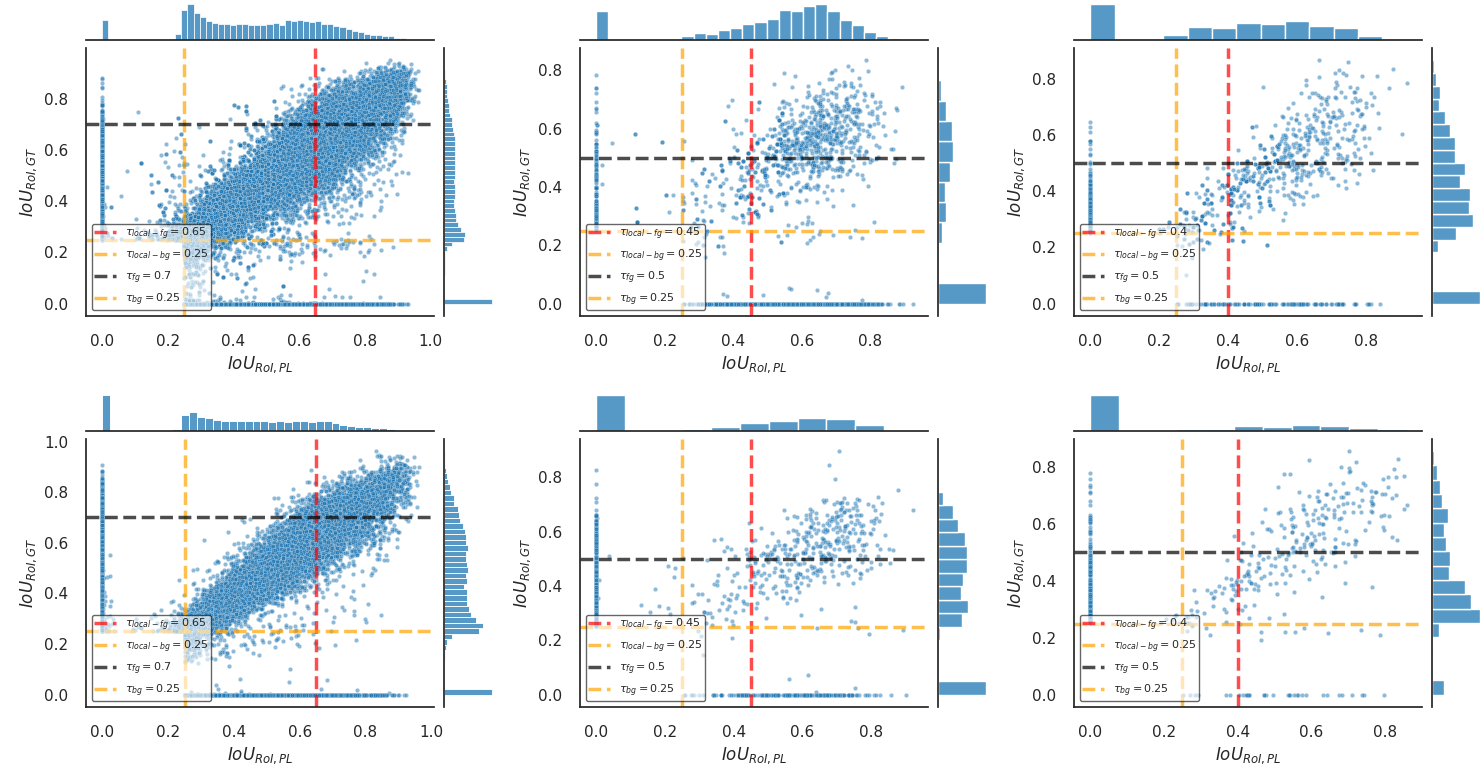

In [25]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())



def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint"):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    epoch_mask = torch.Tensor(df['iteration']).int() > 1339
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap="Reds", shade=True, bw_adjust=.5)
        plt.show()
    else:
        g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5, s=10)
        g.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
        
        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2.5)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2.5)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2.5)
        plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2.5)
        legend = plt.legend(frameon=True, fontsize=8, loc='lower left', borderpad=0.2, framealpha = 0.6)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')
    return g

car_plot_before = get_joint_plot(baseline_df, 'Car', "Before")
car_plot_after = get_joint_plot(df, 'Car', "After")

ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before")
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After")

cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before")
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After")

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(2, 3)

#before
mg0 = SeabornFig2Grid(car_plot_before, fig, gs[0])
mg1 = SeabornFig2Grid(ped_plot_before, fig, gs[1])
mg2 = SeabornFig2Grid(cyc_plot_before, fig, gs[2])
#after
mg3 = SeabornFig2Grid(car_plot_after, fig, gs[3])
mg4 = SeabornFig2Grid(ped_plot_after, fig, gs[4])
mg5 = SeabornFig2Grid(cyc_plot_after, fig, gs[5])

gs.tight_layout(fig)
fig.savefig(fname="ious_new.png", transparent=False, bbox_inches='tight')
plt.show()


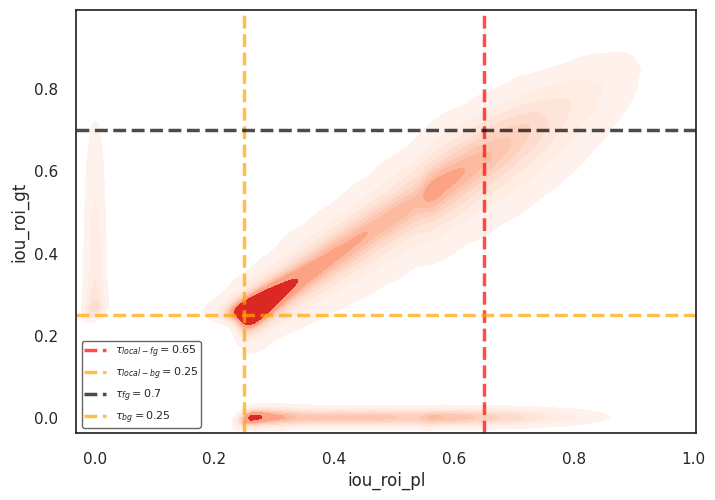

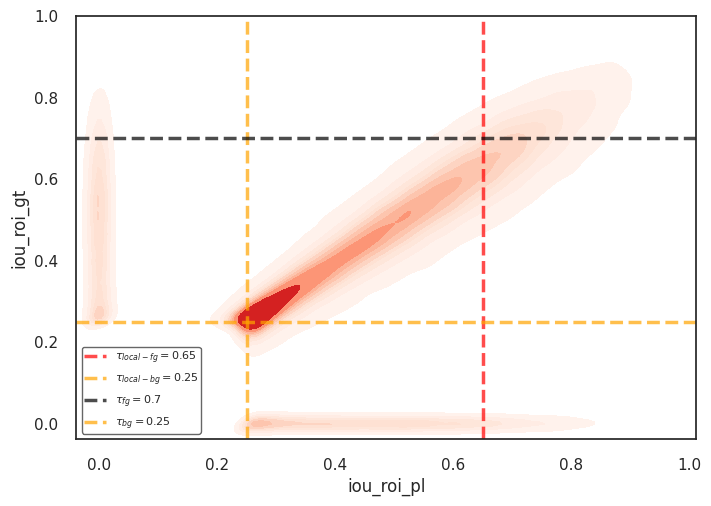

In [5]:
car_plot_before = get_joint_plot(baseline_df, 'Car', "Before", plot_type="kde")
car_plot_after = get_joint_plot(df, 'Car', "After", plot_type="kde")

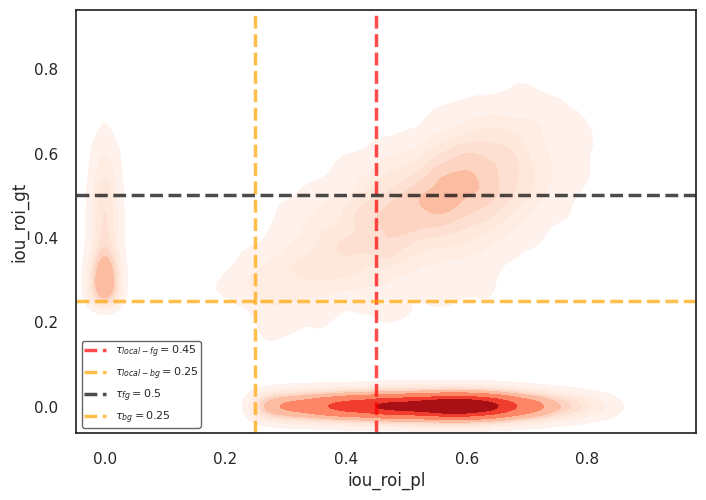

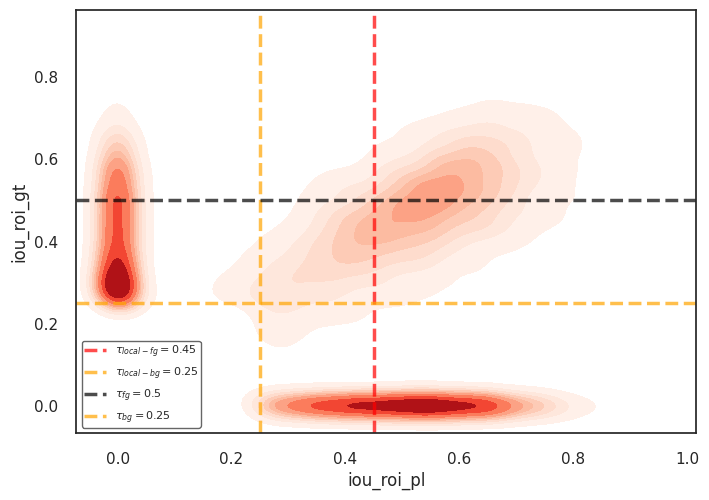

In [6]:
ped_plot_before = get_joint_plot(baseline_df, 'Pedestrian', "Before", plot_type="kde")
ped_plot_after = get_joint_plot(df, 'Pedestrian', "After", plot_type="kde")

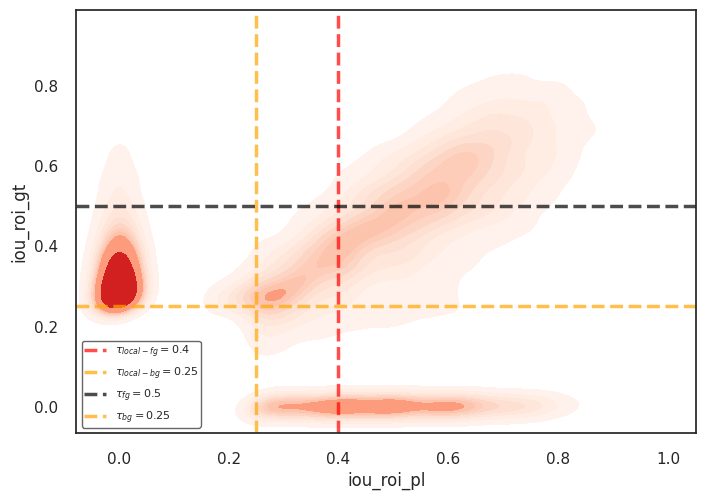

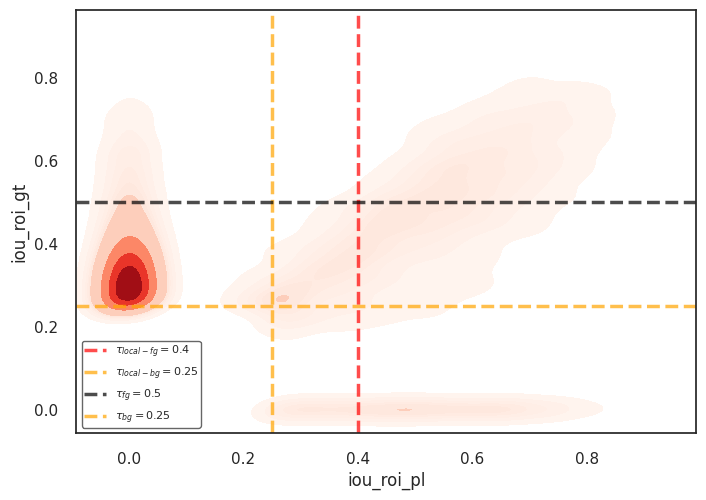

In [7]:
cyc_plot_before = get_joint_plot(baseline_df, 'Cyclist', "Before", plot_type="kde")
cyc_plot_after = get_joint_plot(df, 'Cyclist', "After", plot_type="kde")

In [68]:

def get_joint_plot(df, class_name, fig_title="Default", plot_type="joint"):
    class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
    pl_thresh = {'FG':{'Car': 0.65, 'Pedestrian': 0.45, 'Cyclist': 0.40}, 'BG': 0.25}
    gt_thresh = {'FG':{'Car': 0.70, 'Pedestrian': 0.50, 'Cyclist': 0.50}, 'BG': 0.25}

    class_num = class_to_num[class_name]
    class_mask = (torch.Tensor(df['class_labels'])).int() == class_num
    epoch_mask = torch.Tensor(df['iteration']).int() > 1339
    ignore_bg_mask = ~((torch.Tensor(df['iou_roi_pl']) < pl_thresh['BG']) & (torch.Tensor(df['iou_roi_gt']) < pl_thresh['BG']))
    valid_mask = class_mask & epoch_mask & ignore_bg_mask

    valid_df = pd.DataFrame({'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
                            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
                            'weights': torch.Tensor(df['weights'])[valid_mask],
                            'pred_scores': torch.Tensor(df['pred_scores'])[valid_mask],
                            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]})
    valid_df['class_labels'] = valid_df['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

    if plot_type=='kde':
        g = sns.kdeplot(x=valid_df.iou_roi_pl, y=valid_df.iou_roi_gt, cmap="Reds", shade=True, bw_adjust=.5)
        plt.show()
    else:
        g = sns.jointplot(data=valid_df, x="iou_roi_pl", y="iou_roi_gt", hue='weights', cmap='Blues')
        g.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)

        plt.axvline(x=pl_thresh['FG'][class_name], ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local-fg}=var$".replace('var', str(pl_thresh['FG'][class_name])), alpha = 0.7, lw=2.5)
        plt.axvline(x=pl_thresh['BG'], ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local-bg}=var$".replace('var', str(pl_thresh['BG'])), alpha = 0.7, lw=2.5)
        plt.axhline(y=gt_thresh['FG'][class_name], xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau_{fg}=var$".replace('var', str(gt_thresh['FG'][class_name])), alpha = 0.7, lw=2.5)
        plt.axhline(y=gt_thresh['BG'], xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau_{bg}=var$".replace('var', str(gt_thresh['BG'])), alpha = 0.7, lw=2.5)
        legend = plt.legend(frameon=True, fontsize=8, loc='lower left', borderpad=0.2, framealpha = 0.6)
        frame = legend.get_frame()
        frame.set_color('white')
        frame.set_edgecolor('black')

        # Make space for the colorbar
        g.fig.subplots_adjust(right=.92)

        # Define a new Axes where the colorbar will go
        cax = g.fig.add_axes([.94, .25, .02, .6])
        # Get a mappable object with the same colormap as the data
        points = plt.scatter([], [], c=[], vmin=0, vmax=1, cmap='Blues')

        # Draw the colorbar
        g.fig.colorbar(g, cax=cax).set_label("Weights")

    return g

car_plot_before = get_joint_plot(df, 'Cyclist', "Before")
plt.show()


AttributeError: 'JointGrid' object has no attribute 'get_array'

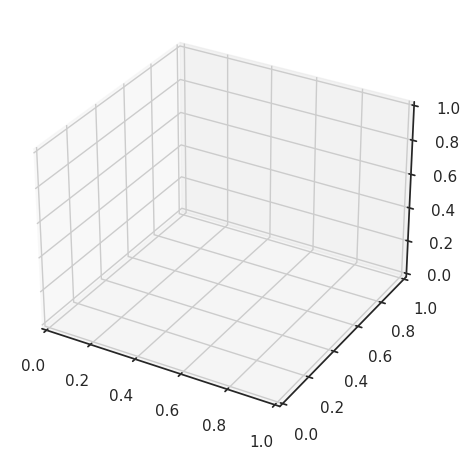

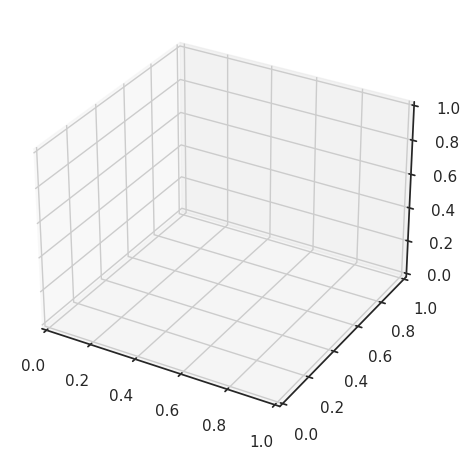

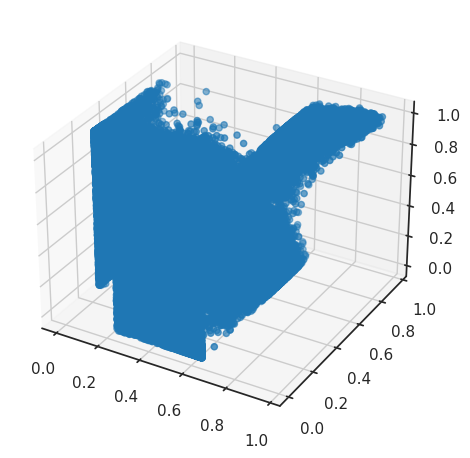

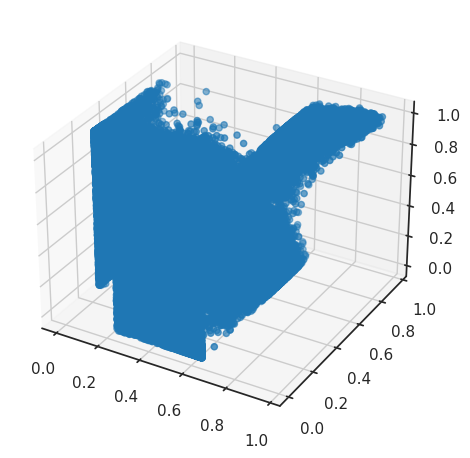

In [11]:
# valid_mask = torch.Tensor(df['iteration']).int() > 0
# valid_mask = valid_mask & ((torch.Tensor(df['class_labels'])).int() == 1)
# valid_mask = valid_mask & ~((torch.Tensor(df['iou_roi_pl'])<0.25) & (torch.Tensor(df['iou_roi_gt']) < 0.25))

valid_mask1 = torch.Tensor(df['iteration']).int() > 0
valid_mask2 = ((torch.Tensor(df['class_labels'])).int() == 1)
valid_mask3 = ~((torch.Tensor(df['iou_roi_pl'])<0.25) & (torch.Tensor(df['iou_roi_gt']) < 0.25))
valid_mask = valid_mask1 & valid_mask2 & valid_mask3

dist_data = {'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
            'weights': torch.Tensor(df['weights'])[valid_mask],
            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]}
dist_df2 = pd.DataFrame(dist_data)
dist_df2['class_labels'] = dist_df2['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(dist_df2.iou_roi_pl[dist_df2.class_labels=='Car'],dist_df2.iou_roi_gt[dist_df2.class_labels=='Car'],dist_df2.weights[dist_df2.class_labels=='Car'])
plt.show()
# g = sns.kdeplot(x=dist_df2.iou_roi_pl, y=dist_df2.iou_roi_gt, cmap="Reds", shade=True, bw_adjust=.5)

# # g0 = sns.jointplot(data=dist_df2, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5)
# g0.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
# plt.axvline(x=0.65, ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local}=0.65$", alpha = 0.7, lw=2.5)
# plt.axvline(x=0.25, ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local}=0.25$", alpha = 0.7, lw=2.5)
# plt.axhline(y=0.7, xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau=0.70$", alpha = 0.7, lw=2.5)
# plt.axhline(y=0.25, xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau=0.25$", alpha = 0.7, lw=2.5)
# legend = plt.legend(frameon=True, fontsize=10, loc='lower left', borderpad=0.2, framealpha = 0.6)
# frame = legend.get_frame()
# frame.set_color('white')
# frame.set_edgecolor('black')
# plt.show()

## ----------------------DND-------------------------

In [103]:
valid_mask = torch.Tensor(df['iteration']).int() > 0
valid_mask = valid_mask & ((torch.Tensor(df['class_labels'])).int() == 2)
valid_mask = valid_mask & ~((torch.Tensor(df['iou_roi_pl'])<0.25) & (torch.Tensor(df['iou_roi_gt']) < 0.25))

dist_data = {'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]}
dist_df2 = pd.DataFrame(dist_data)
dist_df2['class_labels'] = dist_df2['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

g1 = sns.jointplot(data=dist_df2, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5)
g1.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
plt.axvline(x=0.45, ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local}=0.45$", alpha = 0.7, lw=2.5)
plt.axvline(x=0.25, ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local}=0.25$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.5, xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau=0.5$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.25, xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau=0.25$", alpha = 0.7, lw=2.5)
g1.fig.suptitle("Pedestrian")
legend = plt.legend(frameon=True, fontsize=10, loc='lower left', borderpad=0.2, framealpha = 0.6)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')

In [104]:
valid_mask = torch.Tensor(df['iteration']).int() > 0#1392
valid_mask = valid_mask & ((torch.Tensor(df['class_labels'])).int() == 3)
valid_mask = valid_mask & ~((torch.Tensor(df['iou_roi_pl'])<0.25) & (torch.Tensor(df['iou_roi_gt']) < 0.25))

dist_data = {'iou_roi_pl': torch.Tensor(df['iou_roi_pl'])[valid_mask], 
            'iou_roi_gt': torch.Tensor(df['iou_roi_gt'])[valid_mask],
            'class_labels': torch.Tensor(df['class_labels'])[valid_mask]}
dist_df2 = pd.DataFrame(dist_data)
dist_df2['class_labels'] = dist_df2['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})


g2 = sns.jointplot(data=dist_df2, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5)
g2.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
plt.axvline(x=0.4, ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local}=0.4$", alpha = 0.7, lw=2.5)
plt.axvline(x=0.25, ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local}=0.25$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.5, xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau=0.5$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.25, xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau=0.25$", alpha = 0.7, lw=2.5)
g2.fig.suptitle("Cyclist")
legend = plt.legend(frameon=True, fontsize=10, loc='lower left', borderpad=0.2, framealpha = 0.6)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')

In [ ]:


valid_mask = torch.Tensor(baseline_df['iteration']).int() > 0
valid_mask = valid_mask & ((torch.Tensor(baseline_df['class_labels'])).int() == 1)
valid_mask = valid_mask & ~((torch.Tensor(baseline_df['iou_roi_pl']) < 0.25) & (torch.Tensor(baseline_df['iou_roi_gt']) < 0.25))

valid_data_baseline = {'iou_roi_pl': torch.Tensor(baseline_df['iou_roi_pl'])[valid_mask], 
                        'iou_roi_gt': torch.Tensor(baseline_df['iou_roi_gt'])[valid_mask],
                        'class_labels': torch.Tensor(baseline_df['class_labels'])[valid_mask]}
valid_df_baseline = pd.DataFrame(valid_data_baseline)
valid_df_baseline['class_labels'] = valid_df_baseline['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

g3 = sns.jointplot(data=valid_df_baseline, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5)
g3.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
plt.axvline(x=0.65, ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local}=0.65$", alpha = 0.7, lw=2.5)
plt.axvline(x=0.25, ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local}=0.25$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.7, xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau=0.70$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.25, xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau=0.25$", alpha = 0.7, lw=2.5)
g3.fig.suptitle("Car")
legend = plt.legend(frameon=True, fontsize=10, loc='lower left', borderpad=0.2, framealpha = 0.6)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')



valid_mask = torch.Tensor(baseline_df['iteration']).int() > 0
valid_mask = valid_mask & ((torch.Tensor(baseline_df['class_labels'])).int() == 2)
valid_mask = valid_mask & ~((torch.Tensor(baseline_df['iou_roi_pl']) < 0.25) & (torch.Tensor(baseline_df['iou_roi_gt']) < 0.25))

valid_data_baseline = {'iou_roi_pl': torch.Tensor(baseline_df['iou_roi_pl'])[valid_mask], 
                        'iou_roi_gt': torch.Tensor(baseline_df['iou_roi_gt'])[valid_mask],
                        'class_labels': torch.Tensor(baseline_df['class_labels'])[valid_mask]}
valid_df_baseline = pd.DataFrame(valid_data_baseline)
valid_df_baseline['class_labels'] = valid_df_baseline['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

g4 = sns.jointplot(data=valid_df_baseline, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5)
g4.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
plt.axvline(x=0.45, ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local}=0.45$", alpha = 0.7, lw=2.5)
plt.axvline(x=0.25, ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local}=0.25$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.5, xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau=0.5$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.25, xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau=0.25$", alpha = 0.7, lw=2.5)
g4.fig.suptitle("Pedestrian")
legend = plt.legend(frameon=True, fontsize=10, loc='lower left', borderpad=0.2, framealpha = 0.6)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')



valid_mask = torch.Tensor(baseline_df['iteration']).int() > 0
valid_mask = valid_mask & ((torch.Tensor(baseline_df['class_labels'])).int() == 3)
valid_mask = valid_mask & ~((torch.Tensor(baseline_df['iou_roi_pl']) < 0.25) & (torch.Tensor(baseline_df['iou_roi_gt']) < 0.25))

valid_data_baseline = {'iou_roi_pl': torch.Tensor(baseline_df['iou_roi_pl'])[valid_mask], 
                        'iou_roi_gt': torch.Tensor(baseline_df['iou_roi_gt'])[valid_mask],
                        'class_labels': torch.Tensor(baseline_df['class_labels'])[valid_mask]}
valid_df_baseline = pd.DataFrame(valid_data_baseline)
valid_df_baseline['class_labels'] = valid_df_baseline['class_labels'].map({1:'Car', 2:'Pedestrian', 3:'Cyclist'})

g5 = sns.jointplot(data=valid_df_baseline, x="iou_roi_pl", y="iou_roi_gt", alpha=0.5)
g5.set_axis_labels('$IoU_{RoI,PL}$', '$IoU_{RoI,GT}$', fontsize=12)
plt.axvline(x=0.4, ymin=0, ymax=1, linestyle='--', color='red', label="$\\tau_{local}=0.4$", alpha = 0.7, lw=2.5)
plt.axvline(x=0.25, ymin=0, ymax=1, linestyle='--', color='orange', label="$\\tau_{local}=0.25$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.5, xmin=0, xmax=1, linestyle='--', color='black', label="$\\tau=0.5$", alpha = 0.7, lw=2.5)
plt.axhline(y=0.25, xmin=0, xmax=1, linestyle='--', color='orange', label="$\\tau=0.25$", alpha = 0.7, lw=2.5)
g5.fig.suptitle("Cyclist")
legend = plt.legend(frameon=True, fontsize=10, loc='lower left', borderpad=0.2, framealpha = 0.6)
frame = legend.get_frame()
frame.set_color('white')
frame.set_edgecolor('black')

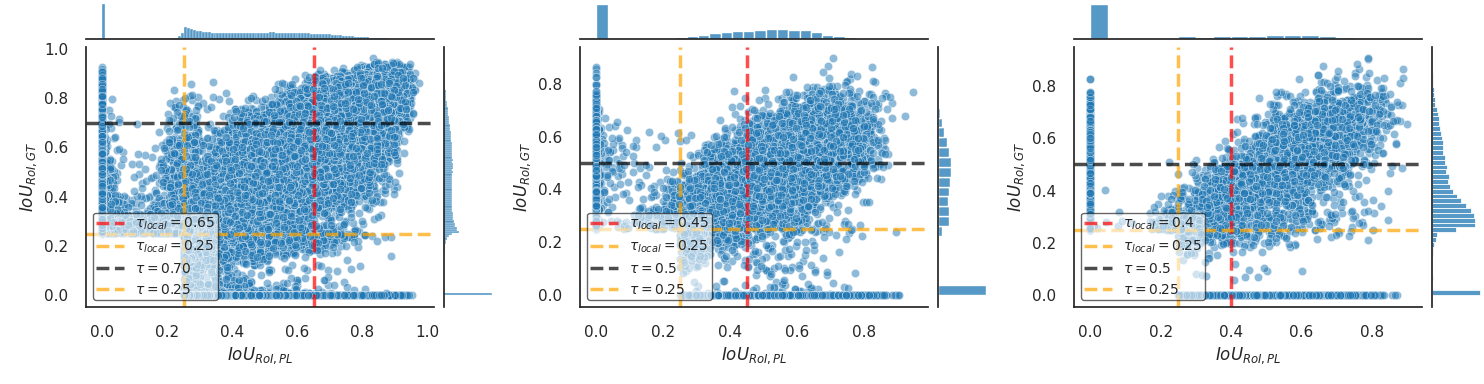

In [105]:
import matplotlib.gridspec as gridspec

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 3)

#before
mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])

# #after
# mg3 = SeabornFig2Grid(g3, fig, gs[3])
# mg4 = SeabornFig2Grid(g4, fig, gs[4])
# mg5 = SeabornFig2Grid(g5, fig, gs[5])

gs.tight_layout(fig)
fig.savefig(fname="ious.png", transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
# convert list to tensors
iou_roi_pl = torch.Tensor(df['iou_roi_pl'])
iou_roi_gt = torch.Tensor(df['iou_roi_gt'])
pred_scores = torch.sigmoid(torch.Tensor(df['pred_scores'])) # normlalise pred scores
class_labels = torch.Tensor(df['class_labels'])
iteration = torch.Tensor(df['iteration'])
print("Total iterations: ", iteration[-1].item())

# map (0,1439) iterations to (1,8), can be changed later
last_iter = int(max(df['iteration']))
interval_range = last_iter // 8
mapped_iteration = torch.Tensor([int(max(1, min((iter+(interval_range-1))//interval_range, 8))) for iter in df['iteration']])

# create classwise masks and extract their corresponding scores
class_to_num = {'Car': 1, 'Pedestrian': 2, 'Cyclist': 3}
scores_df = pd.DataFrame()
scores_df = {'iou_roi_pl': {'Car': None, 'Pedestrian': None, 'Cyclist': None}, 
            'iou_roi_gt': {'Car': None, 'Pedestrian': None, 'Cyclist': None}, 
            'pred_scores': {'Car': None, 'Pedestrian': None, 'Cyclist': None},
            'mapped_iteration': {'Car': None, 'Pedestrian': None, 'Cyclist': None}}
for class_name, class_val in class_to_num.items():
    scores_df['iou_roi_pl'][class_name] = iou_roi_pl[class_labels==class_val]
    scores_df['iou_roi_gt'][class_name] = iou_roi_gt[class_labels==class_val]
    scores_df['pred_scores'][class_name] = pred_scores[class_labels==class_val]
    scores_df['mapped_iteration'][class_name] = mapped_iteration[class_labels==class_val]
    
    print(scores_df['iou_roi_pl'][class_name].shape, scores_df['iou_roi_gt'][class_name].shape, 
        scores_df['pred_scores'][class_name].shape, scores_df['mapped_iteration'][class_name].shape)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

for cls in ['Car','Pedestrian', 'Cyclist'] :
    fig = sns.kdeplot(scores_df['iou_roi_pl'][cls][scores_df['iou_roi_pl'][cls] > 0.25], shade=True, color="r", label='iou_roi_pl').set_title("IoUs for Pedestrian")
    fig = sns.kdeplot(scores_df['iou_roi_gt'][cls][scores_df['iou_roi_gt'][cls] > 0.25], shade=True, color="b", label='iou_roi_gt')
    legend = plt.legend(frameon=True)
    frame = legend.get_frame()
    frame.set_color('white')
    frame.set_edgecolor('black')
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
class_name = "Pedestrian"
x = scores_df['iou_roi_pl'][class_name][scores_df['iou_roi_pl'][class_name] > 0.25]
g = scores_df['mapped_iteration'][class_name][scores_df['iou_roi_pl'][class_name] > 0.25].int()
df = pd.DataFrame()
df['IoU between ROI and PL'] = x
df['Train interval'] = g

# # Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="Train interval", hue="Train interval", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "IoU between ROI and PL",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "IoU between ROI and PL", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "IoU between ROI and PL")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
plt.show()